In [2]:
import qutip as q
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as cf

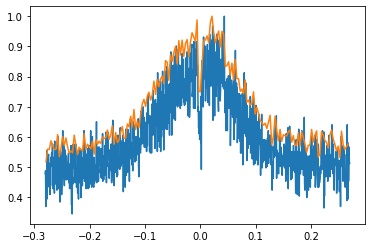

In [35]:
def horizontal_bin(x_arr, y_arr, stat_func=np.mean, resolution=5):
    x_arr = stat_func(x_arr[:resolution * int(len(x_arr)/resolution)].reshape(int(len(x_arr)/resolution),resolution), axis = 1)
    y_arr = stat_func(y_arr[:resolution * int(len(y_arr)/resolution)].reshape(int(len(y_arr)/resolution),resolution), axis = 1)
    return x_arr, y_arr

data = np.genfromtxt(r"Data\CPT\307nW-10dB.txt")
deltas = data[:,0]
cts = data[:,1]
deltas_binned, cts_binned = horizontal_bin(deltas, cts, resolution=6)

deltas = deltas-3.53
deltas_binned = deltas_binned-3.53
cts = cts/np.amax(cts)
cts_binned = cts_binned/np.amax(cts_binned)

plt.plot(deltas, cts)
plt.plot(deltas_binned, cts_binned)

In [102]:
a1 = q.basis(6,0)
a2 = q.basis(6,1)
b1 = q.basis(6,2)
b2 = q.basis(6,3)
c1 = q.basis(6,4)
c2 = q.basis(6,5)

Gamma_pure_deph = 1/(2*np.pi*1e3)

def cpt(deltas, eta, Delta, OmegaC1, OmegaC3, Gamma_pht, T1_orb, T1_spin, T2_pure_deph):

    HintC1 = OmegaC1/2*(a1*c2.dag() + c2*a1.dag()) 
    HintC3 = OmegaC3/2*(a2*c2.dag() + c2*a2.dag())
    
    Gamma_phn = 1/(2*np.pi*T1_orb)
    Gamma_spin = 1/(2*np.pi*T1_spin)
    Gamma_pure_deph = 1/(2*np.pi*T2_pure_deph)

    Gamma_a1 = (np.sqrt(Gamma_phn)*(eta*b2+b1) + np.sqrt(Gamma_spin)*a2)*a1.dag()
    Gamma_a2 = (np.sqrt(Gamma_phn)*(eta*b1+b2) + np.sqrt(Gamma_spin)*a1)*a2.dag()
    Gamma_b1 = (np.sqrt(Gamma_phn)*(eta*a2+a1) + np.sqrt(Gamma_spin)*b2)*b1.dag()
    Gamma_b2 = (np.sqrt(Gamma_phn)*(eta*a1+a2) + np.sqrt(Gamma_spin)*b1)*b2.dag()
    Gamma_c1 = (np.sqrt(Gamma_pht)*(eta*(b2+a2)+b1+a1) + np.sqrt(Gamma_spin)*c2)*c1.dag()
    Gamma_c2 = (np.sqrt(Gamma_pht)*(eta*(b1+a1)+b2+a2) + np.sqrt(Gamma_spin)*c1)*c2.dag()
    
    Gamma_deph = np.sqrt(Gamma_pure_deph)*(a2*a2.dag()-a1*a1.dag())
    Gammas = [Gamma_a1, Gamma_a2, Gamma_b1, Gamma_b2, Gamma_c1, Gamma_c2, Gamma_deph]

    c_ops = []
    for Gamma in Gammas:
        c_ops.append(Gamma)

    rho_ss_c1 = np.zeros_like(deltas)
    for i, delta in enumerate(deltas):
        Hsys = (delta-Delta)*a2*a2.dag() + Delta*c2*c2.dag()
        
        # H = [Hsys, [HintC1, seq_C1], [HintC3, seq_C3]]

        rho_ss = q.steadystate(Hsys+HintC1+HintC3, c_ops)
        rho_ss_c1[i] = np.abs(rho_ss[-1,-1])
    rho_ss_c1 = rho_ss_c1/np.amax(rho_ss_c1) 
    return rho_ss_c1


In [109]:
eta = 0.01 # branching ratio
Delta = 0.00053487
Gamma_pht = 0.080
OmegaC1 = 0.02103286
OmegaC3 = 0.01227321
T1_orb = 46
T1_spin = 170
T2_pure_deph = 20000

p0 = (eta, Delta, OmegaC1, OmegaC3, Gamma_pht, T1_orb, T1_spin, T2_pure_deph)
bounds = np.array([
            (1e-2, -0.5, 1e-3, 1e-3, 70e-3, 10, 10, 10),
            (1e2, 0.5, 1, 1, 5e-1, 100, 1000, 1000)])

popt, pcov = cf(cpt, deltas_binned, cts_binned, p0=p0, bounds=bounds, method='trf')
plt.plot(deltas_binned, cts_binned)
plt.plot(deltas_binned, cpt(deltas_binned, *popt))

ValueError: `x0` is infeasible.

In [108]:
#a, eta, Delta, OmegaC1, OmegaC3, Gamma_pht
print(popt)

[1.00000000e-02 4.13850735e-05 2.39066294e-02 6.33035727e-03
 7.00000000e-02 1.00000000e+02 1.00000000e+03 1.00000000e+03]


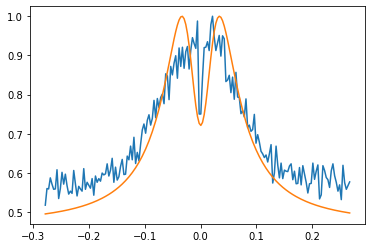

In [91]:
a = 1
eta = 0.3 # branching ratio
Delta = 0
Gamma_pht = 0.07
OmegaC1 = 0.02
OmegaC3 = 0.05
fit_cpt = cpt(deltas_binned, eta, Delta, Gamma_pht, OmegaC1, OmegaC3)

plt.plot(deltas_binned, cts_binned)

plt.plot(deltas_binned, fit_cpt)

Text(0.05,0.95,'Linewidth 0.42\n 1/T2* 0.07')

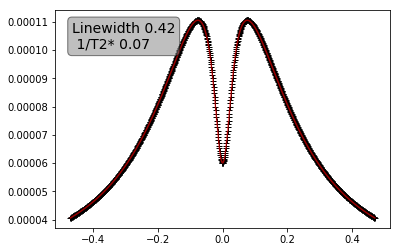

In [37]:
def lorentzian(x, x0, Gamma):
    return (Gamma/2)**2/((x-x0)**2 + (Gamma/2)**2)

def double_lorentzian_fit(x, x01, x02, Gamma1, Gamma2, a1, a2, c):
    return a1*lorentzian(x, x01, Gamma1) + a2*lorentzian(x, x02, Gamma2) +c 

p0 = (Delta, 0, 2*0.5*(1/((Gamma_pht**2/(2*OmegaC1**2))+1)), 100*Gamma_phn/2, np.abs(np.amax(c_ss_c1)), -np.abs(np.amax(c_ss_c1)), np.abs(np.amin(c_ss_c1)))
popt, pcov = cf(
                double_lorentzian_fit, 
                deltas, np.abs(c_ss_c1),
                p0=p0)

fig, axs = plt.subplots()
axs.plot(deltas, np.abs(c_ss_c1), '+k')
axs.plot(deltas, double_lorentzian_fit(deltas, *popt), '-r', alpha=0.6)
props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

# place a text box in upper left in axes coords
axs.text(0.05, 0.95, f"Linewidth {round(popt[2],2)}\n 1/T2* {round(popt[3],2)}", transform=axs.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)